# Eikonal solver with Physics-Informed Neural Networks (PINNs) - Constant velocity

In this lab of the **ErSE 222 - Machine Learning in Geoscience** course, we will look at a new family of NN-based algorithms for modelling of physical processes governed by a Partial-Differential Equation (PDE), the so called Physics-Informed Neural Networks (PINNs).

The idea of PINNs is rather easy. A NN is trained to learn a mapping between the indipendent and dependant coordinates of the PDE and the PDE itself is used as the loss function that drives the training process. Once a PINN is trained, it can produce a mesh-free solution of the underlying PDE at any location of interest in a fraction of the time of usual discretization-based PDE solvers (e.g., FD, FEM, SEM).

In this notebook we will consider a very popular PDE in geophysics, the so-called **Eikonal equation**:

$$
|\nabla T|^2 = \frac{1}{v^2}
$$ 

Such a PDE can be solved to estimate the time-of-flight or traveltime $T$ between any two points in a domain with a certain spatially-variant velocity $v(x,z)$. 

In the following we consider the factorized Eikonal equation as suggested in [bin Waheed et al., 2020](https://arxiv.org/abs/2007.08330):

$$
T_0^2|\nabla \tau|^2 + \tau^2|\nabla T_0|^2 + 2 T_0 \tau (\nabla T_0 \cdot \nabla \tau)= \frac{1}{v^2}, \quad \tau(x_S)=1
$$ 

where $T_0$ is the traveltime in a reference medium with analytical solution and $\tau$ is a correction factor that we wish to learn.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import skfmm

from torch.utils.data import TensorDataset, DataLoader
from utils import *
from model import *
from train import *

In [2]:
set_seed(10)
device = set_device()

No GPU available!


## Constant velocity

Our first example considers the case of a constant velocity model. Here since we know the solution analytically, we have:

$$
T(x,z)=T_0(x,z), \quad \tau(x,z)=1.
$$

Therefore, we want to see if our network can learn to always output $1.$ no matter what $x,z$ pair is given as input.

### Parameters

In [3]:
# Network
act = 'Tanh'
lay = 'linear' # 'adaptive'
unit = 100
hidden = 3

# Scaling
scaling = 10.

# Optimizer
opttype = 'adam'
lr = 1e-3
epochs = 1000
perc = 0.25 # 0.25
randompoints = True
batch_size = 256
pretrain = False

# Weights
lambda_pde, lambda_init = 1., 10. # 1, 10

### Geometry and initial traveltime

In [4]:
# Model grid (km)
ox, dx, nx = 0., 10./1000., 101 
oz, dz, nz = 0., 10./1000., 201 

# Velocity model (km/s)
v0 = 1000./1000.
vscaler = 1. #v0**2
vel = v0 * np.ones((nx, nz))

# Source (km)
xs, zs = 500./1000., 500./1000.

In [5]:
# Computational domain
x, z, X, Z = eikonal_grid(ox, dx, nx, oz, dz, nz)
    
# Analytical solution
tana, _, _ = eikonal_constant(ox, dx, nx, oz, dz, nz, xs, zs, v0)
t0, t0_dx, t0_dz = eikonal_constant(ox, dx, nx, oz, dz, nz, xs, zs, v0)
t0_dx_numerical, t0_dz_numerical = np.gradient(t0, dx, dz)

# Eikonal solution
teik = eikonal_fmm(ox, dx, nx, oz, dz, nz, xs, zs, vel)

# Factorized eikonal solution: t= tau * t0
tauana = tana / t0
tauana[np.isnan(tauana)] = 1.

/Users/ravasim/Desktop/KAUST/Teaching/MLgeoscience/CourseNotes/labs/notebooks/EikonalPINN/utils.py:55: RuntimeWarning: invalid value encountered in true_divide
  tana_dx = (X - xs) / (dana.ravel() * v)
/Users/ravasim/Desktop/KAUST/Teaching/MLgeoscience/CourseNotes/labs/notebooks/EikonalPINN/utils.py:56: RuntimeWarning: invalid value encountered in true_divide
  tana_dz = (Z - zs) / (dana.ravel() * v)
/Users/ravasim/opt/anaconda3/envs/mlcourse/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


/Users/ravasim/opt/anaconda3/envs/mlcourse/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: The following kwargs were not used by contour: 'label'
  import sys
/Users/ravasim/opt/anaconda3/envs/mlcourse/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'label'
  
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


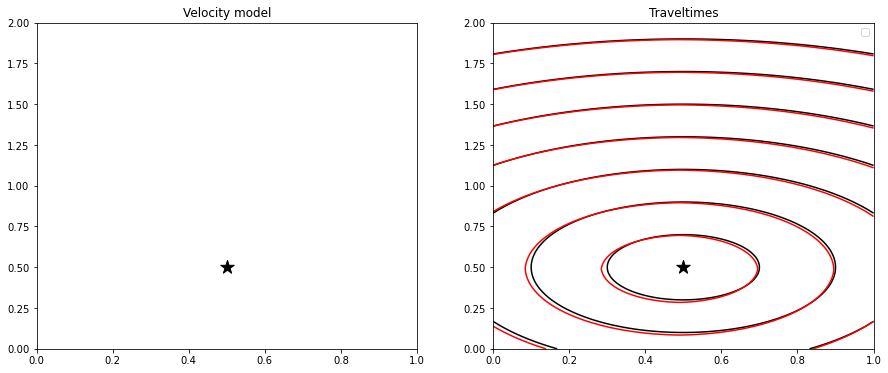

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))
axs[0].imshow(vel.T, extent=(x[0], x[-1], z[0], z[-1]), cmap='gray_r', origin='lower')
axs[0].scatter(xs, zs, s=200, marker='*', color='k')
axs[0].set_title('Velocity model')
axs[0].axis('tight')

axs[1].contour(tana.T, extent=(x[0], x[-1], z[0], z[-1]), colors='k', label='Analytical')
axs[1].contour(teik.T, extent=(x[0], x[-1], z[0], z[-1]), colors='r', label='Numerical')
axs[1].scatter(xs, zs, s=200, marker='*', color='k')
axs[1].set_title('Traveltimes')
axs[1].legend()
axs[1].axis('tight');

It is interesting to observe how a numerical solution based on the Fast-Marching Method (FMM) does actually produce some error due to the coarse discretization. This may be improved refining the discrete grid at the cost of running a more expensive simulation.

### Training data and network

In [7]:
# Apply scaling
X, Z, Xs, Zs = X/scaling, Z/scaling, xs/scaling, zs/scaling

In [8]:
# Remove source from grid of points to be used in training
X_nosrc, Z_nosrc, v_nosrc, t0_nosrc, t0_dx_nosrc, t0_dz_nosrc = \
    remove_source(X, Z, Xs, Zs, vel, t0, t0_dx, t0_dz)

In [9]:
# Create evaluation grid
grid_loader = create_gridloader(X, Z, device)

In [10]:
# Define and initialize network
model = Network(2, 1, [unit]*hidden, act=act, lay=lay)
model.to(device)
#model.apply(model.init_weights)
print(model)

Network(
  (model): Sequential(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=100, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): Tanh()
    )
    (3): Linear(in_features=100, out_features=1, bias=True)
  )
)


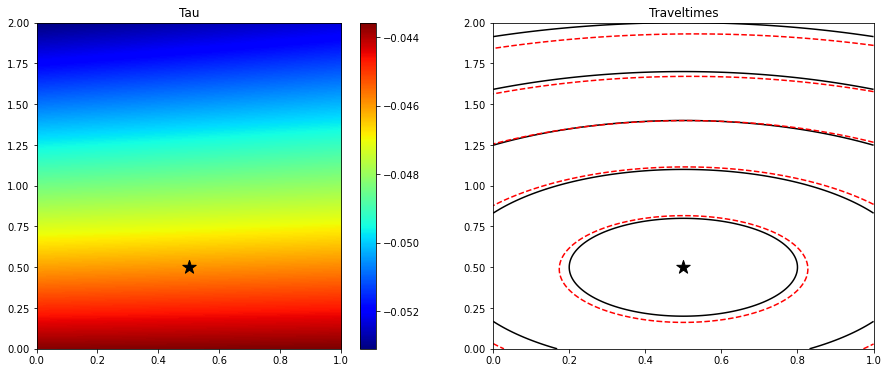

In [11]:
# Compute traveltime with randomly initialized network 
tau_est_init = evaluate(model, grid_loader)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))
im = axs[0].imshow(tau_est_init.detach().cpu().numpy().reshape(nx, nz).T, 
                   extent=(x[0], x[-1], z[0], z[-1]), cmap='jet', origin='lower')
axs[0].scatter(xs, zs, s=200, marker='*', color='k')
axs[0].set_title('Tau')
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])

axs[1].contour(tana.T, extent=(x[0], x[-1], z[0], z[-1]), colors='k', levels=5)
axs[1].contour((tau_est_init.detach().cpu().numpy().reshape(nx, nz) * t0).T, 
               extent=(x[0], x[-1], z[0], z[-1]), colors='r', levels=5)
axs[1].scatter(xs, zs, s=200, marker='*', color='k')
axs[1].set_title('Traveltimes')
axs[1].axis('tight');

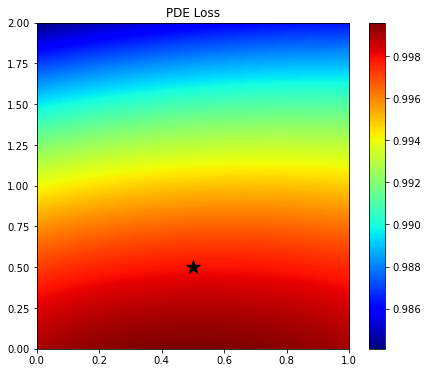

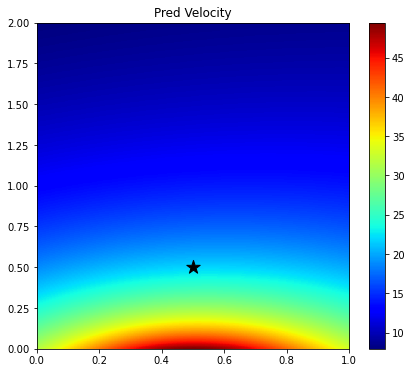

In [12]:
# Compute PDE loss
pde_loader, _ = create_dataloader(X, Z, Xs, Zs, vel.ravel(), t0.ravel(), t0_dx.ravel(), t0_dz.ravel(), 
                                  perc=1., shuffle=False)

pde, vpred = evaluate_pde(model, pde_loader, vscaler=vscaler)

plt.figure(figsize=(7, 6))
im = plt.imshow(np.abs(pde.detach().cpu().numpy().reshape(nx, nz).T),
                extent=(x[0], x[-1], z[0], z[-1]), cmap='jet', origin='lower')
plt.scatter(xs, zs, s=200, marker='*', color='k')
plt.title('PDE Loss')
plt.axis('tight')
plt.colorbar(im);

plt.figure(figsize=(7, 6))
im = plt.imshow(vpred.detach().cpu().numpy().reshape(nx, nz).T,
                extent=(x[0], x[-1], z[0], z[-1]), cmap='jet', origin='lower')
plt.scatter(xs, zs, s=200, marker='*', color='k')
plt.title('Pred Velocity')
plt.axis('tight')
plt.colorbar(im);

Since here we have used a randomly initialized network, the output $\tau$ over the entire grid is not constant, rather it shows a smooth trend. The solution is therefore very inaccurate. Let's see if training can fix that.

### Train and compute traveltime in entire grid

Number of points used per epoch:5075
Epoch 0, Loss 1.9447317
Recreate dataloader...
Number of points used per epoch:5075
Epoch 100, Loss 0.0001057
Epoch 200, Loss 0.0000217
Epoch 300, Loss 0.0007205
Epoch 400, Loss 0.0000099
Epoch 500, Loss 0.0005358
Epoch 600, Loss 0.0000113
Epoch 700, Loss 0.0000298
Epoch 800, Loss 0.0000088
Epoch 900, Loss 0.0000088


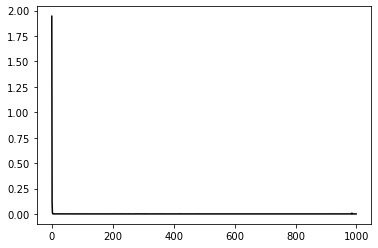

In [14]:
# Optimizer
if opttype == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999), eps=1e-5)
elif opttype == 'lbfgs':
    optimizer = torch.optim.LBFGS(model.parameters(), line_search_fn="strong_wolfe")

# Training
loss_history, loss_pde_history, loss_ic_history, tau_history = \
    training_loop(X_nosrc, Z_nosrc, Xs, Zs, v_nosrc, t0_nosrc, t0_dx_nosrc, t0_dz_nosrc,
                  model, optimizer, epochs, Xgrid=X, Zgrid=Z,
                  randompoints=randompoints, batch_size=batch_size, perc=perc, 
                  lossweights=(lambda_pde, lambda_init), device=device)

plt.figure()
plt.plot(loss_history, 'k');

plt.figure()
plt.semilogy(loss_history, 'k');

/Users/ravasim/opt/anaconda3/envs/mlcourse/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: The following kwargs were not used by contour: 'label'
  if sys.path[0] == '':
/Users/ravasim/opt/anaconda3/envs/mlcourse/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: The following kwargs were not used by contour: 'label'
  


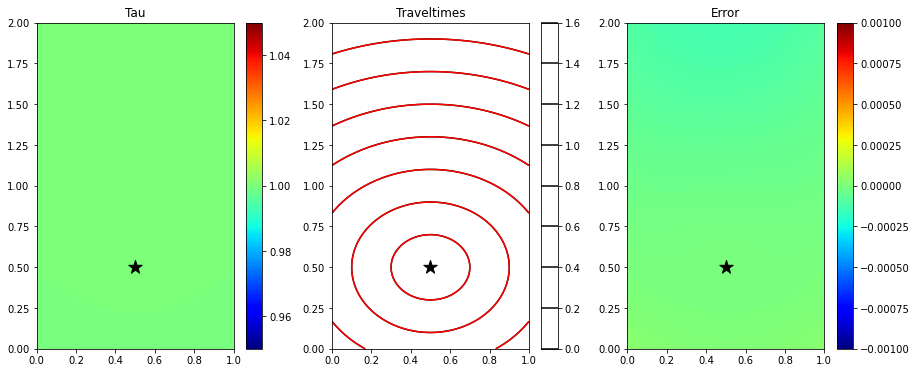

In [15]:
# Compute traveltime with trained network 
tau_est = evaluate(model, grid_loader)

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
im = axs[0].imshow(tau_est.detach().cpu().numpy().reshape(nx, nz).T, vmin=0.95, vmax=1.05,
                   extent=(x[0], x[-1], z[0], z[-1]), cmap='jet', origin='lower')
axs[0].scatter(xs, zs, s=200, marker='*', color='k')
axs[0].set_title('Tau')
axs[0].axis('tight')
plt.colorbar(im, ax=axs[0])

im = axs[1].contour(tana.T, extent=(x[0], x[-1], z[0], z[-1]), colors='k', label='Analytical')
axs[1].contour((tau_est.detach().cpu().numpy().reshape(nx, nz) * t0).T, 
               extent=(x[0], x[-1], z[0], z[-1]), colors='r', label='Estimated')
axs[1].scatter(xs, zs, s=200, marker='*', color='k')
axs[1].set_title('Traveltimes')
#axs[1].legend()
axs[1].axis('tight')
plt.colorbar(im, ax=axs[1])
im = axs[2].imshow(tana.T-(tau_est.detach().cpu().numpy().reshape(nx, nz) * t0).T, 
                   vmin=-0.001, vmax=0.001,
                   extent=(x[0], x[-1], z[0], z[-1]), cmap='jet', origin='lower')
axs[2].scatter(xs, zs, s=200, marker='*', color='k')
axs[2].set_title('Error')
axs[2].axis('tight')
plt.colorbar(im, ax=axs[2]);

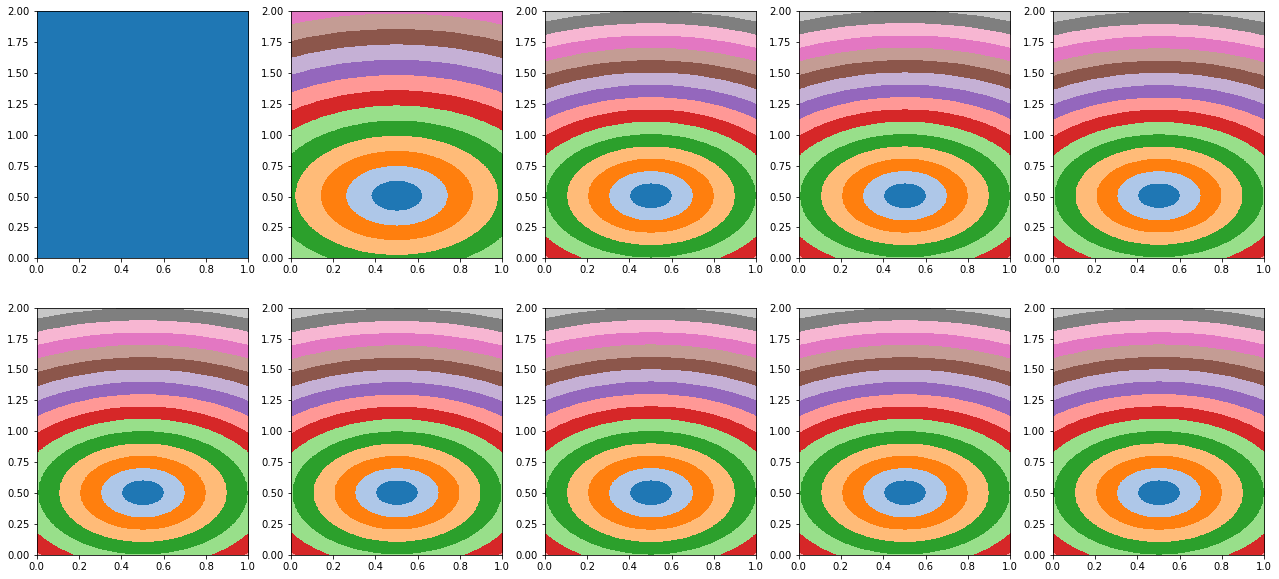

In [16]:
fig, axs = plt.subplots(2, len(tau_history)//2 , figsize=(len(tau_history)*2, 10))
axs = axs.ravel()

for ax, tau in zip(axs, tau_history):
    ax.imshow((tau.detach().cpu().numpy().reshape(nx, nz) * tana).T, 
              extent=(x[0], x[-1], z[0], z[-1]), cmap='tab20', origin='lower', vmin=0., vmax=2.)
    ax.axis('tight')

In [17]:
error = np.linalg.norm(tana.ravel()-(tau_est.detach().cpu().numpy().reshape(nx, nz) * tana).ravel())
print('Overall error', error)

Overall error 0.008424000067299325


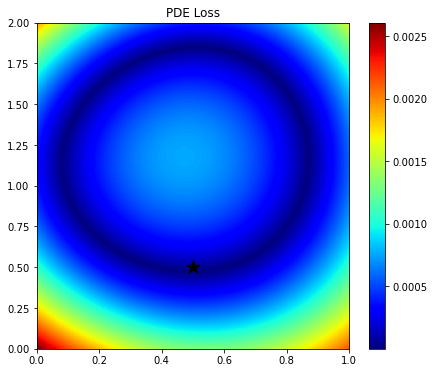

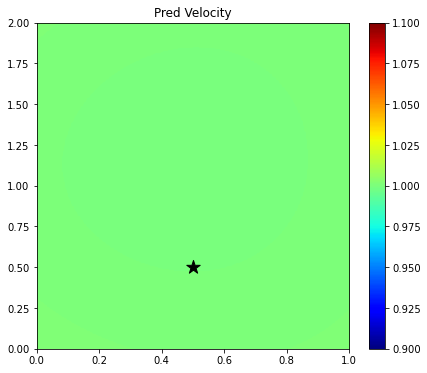

In [18]:
# Compute PDE loss
pde_loader, _ = create_dataloader(X, Z, Xs, Zs, vel.ravel(), t0.ravel(), t0_dx.ravel(), t0_dz.ravel(), 
                                  perc=1., shuffle=False)

pde, vpred = evaluate_pde(model, pde_loader, vscaler=vscaler)

plt.figure(figsize=(7, 6))
im = plt.imshow(np.abs(pde.detach().cpu().numpy().reshape(nx, nz).T),
                extent=(x[0], x[-1], z[0], z[-1]), cmap='jet', origin='lower')
plt.scatter(xs, zs, s=200, marker='*', color='k')
plt.title('PDE Loss')
plt.axis('tight')
plt.colorbar(im);

plt.figure(figsize=(7, 6))
im = plt.imshow(vpred.detach().cpu().numpy().reshape(nx, nz).T, vmin=0.9*v0, vmax=1.1*v0,
                extent=(x[0], x[-1], z[0], z[-1]), cmap='jet', origin='lower')
plt.scatter(xs, zs, s=200, marker='*', color='k')
plt.title('Pred Velocity')
plt.axis('tight')
plt.colorbar(im);